# 04 Register phase volumes to noncon (Round 1: using ANTS)

In future: just the second round version (05) can be used, ANTS gave me more errors

In [1]:
import pandas as pd
import numpy as np
import os
import nibabel as nib
import ants # env to use: reg-36
os.environ["PATH"] += ':/netopt/rhel7/versions/ANTs/2.2/antsbin/bin:'
from util import get_mask_fname, crop_nifti_z, auto_register_z, fix_reg_nslice, register_nifti_affine, register_nifti_syn, view_reg_path, view_reg_mask_path

In [ ]:
help( ants.affine_initializer)

### Registration Functions

In [38]:
# OLD FUNCTIONS (newer functions are in utils.py)

def register_nifti(noncon_nii, phase_nii, phase_nii_reg): 
    phase2noncon = ants.ApplyTransforms()
    phase2noncon.inputs.input_image = phase_nii
    phase2noncon.inputs.reference_image = noncon_nii
    phase2noncon.inputs.output_image = phase_nii_reg
    phase2noncon.inputs.transforms = 'identity'
    phase2noncon.cmdline
    phase2noncon.run()


def crop_nifti_z_auto(nifti_to_crop, ref_nifti):
    ref_image = nib.load(ref_nifti)
    ref_z_max = ref_image.shape[2]
    nii_image = nib.load(nifti_to_crop)
    nii_z_max = nii_image.shape[2]
    rem = (nii_z_max - ref_z_max) // 2
    index_1 = rem
    index_2 = nii_z_max - rem 

    nifti_cropped = nifti_to_crop[:-7] + '_cropped.nii.gz'
    new_img = nii_image.slicer[:,:,index_1:index_2]
    nib.save(new_img, nifti_cropped)

    return nifti_cropped

#ANTS registration function 
def register_nifti_2(noncon_nii, phase_nii, phase_nii_reg):
    reg = ants.Registration()
    reg.inputs.fixed_image = noncon_nii
    reg.inputs.moving_image = phase_nii
    reg.inputs.output_warped_image = phase_nii_reg
    reg.inputs.transforms = ['Affine']
    reg.inputs.transform_parameters = [(2.0,)]
    #reg.inputs.transforms = ['SyN']
    #reg.inputs.transform_parameters = [(3.0,)]
    reg.inputs.number_of_iterations = [[20]]
    reg.inputs.metric = ['MeanSquares'] #vary
    reg.inputs.metric_weight = [1]
    reg.inputs.interpolation = 'NearestNeighbor' #vary
    reg.inputs.smoothing_sigmas = [[1]]
    reg.inputs.shrink_factors = [[2]]
    #reg.inputs.verbose = True
    reg.cmdline
    reg.run()

## Automated: Register all phases of each patient to noncon scan

In [9]:
csv_filepath = '/data/larson2/RCC_dl/metadata/anon_metadata_phase.csv'
df = pd.read_csv(csv_filepath)
base_dir = '/data/larson2/RCC_dl/data2022'

pids = os.listdir(base_dir) #use patients that we have noncon for (i.e. have a folder in /data2022)
print(len(pids))

842


----------------------index: 716 PID: nh1sRqpU6L ------------------------------
d: [5.0, 5.0, 5.0]
['portven', 'delay']
36 68.0 65
36 71.0 65
minz, midz, maxz: 60.0 65.0 69.0
--------- portven ---------


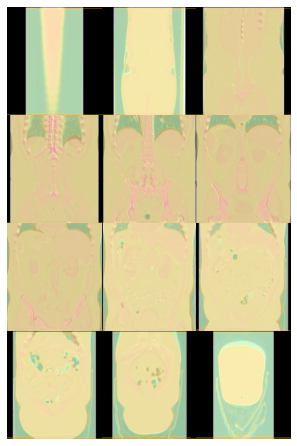

(512, 512, 101)
(512, 512, 101)


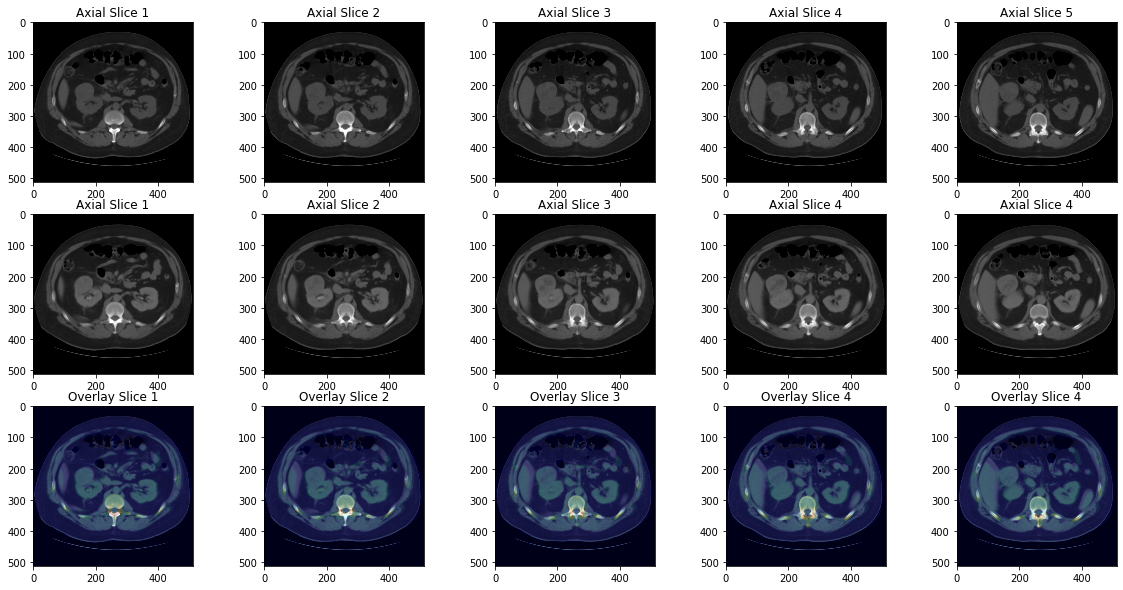

(512, 512, 101)
(512, 512, 101)


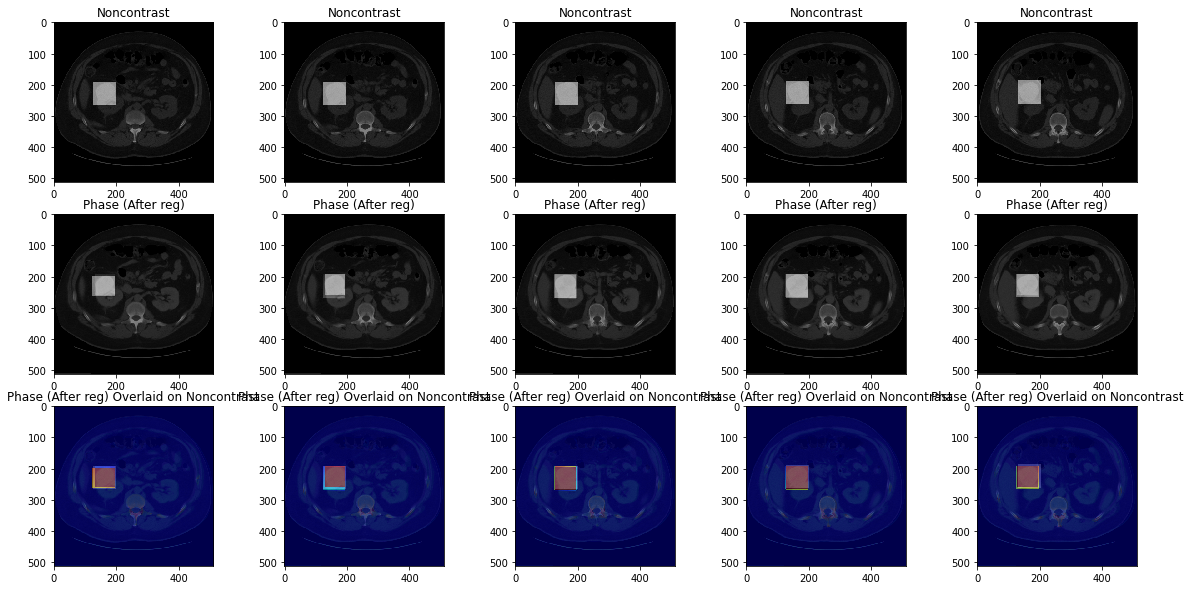

--------- delay ---------


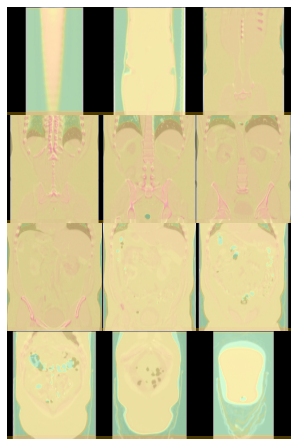

(512, 512, 101)
(512, 512, 101)


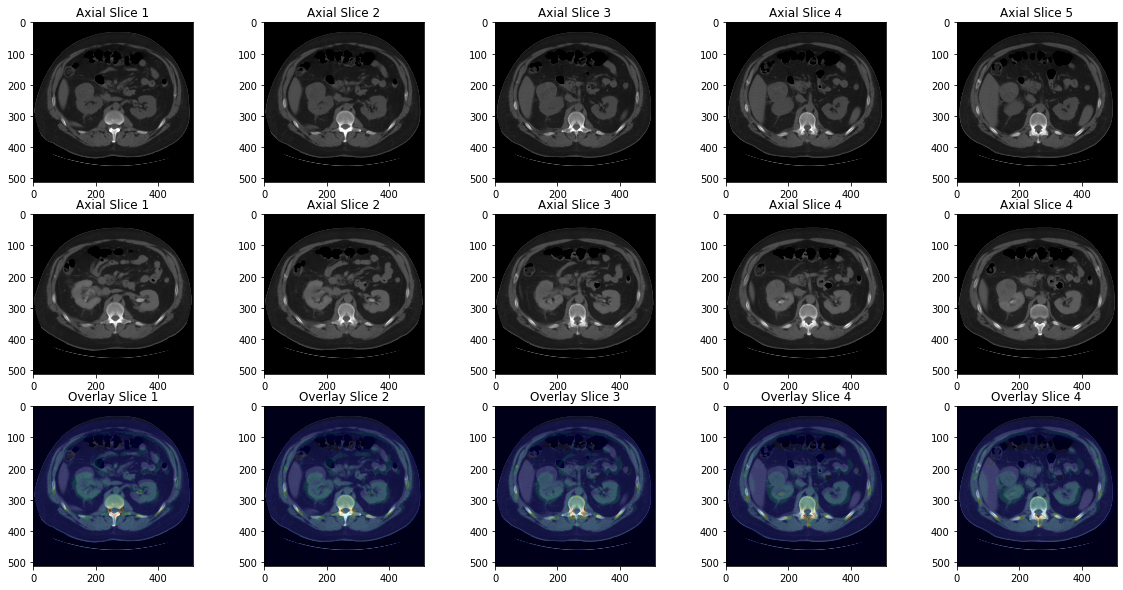

(512, 512, 101)
(512, 512, 101)


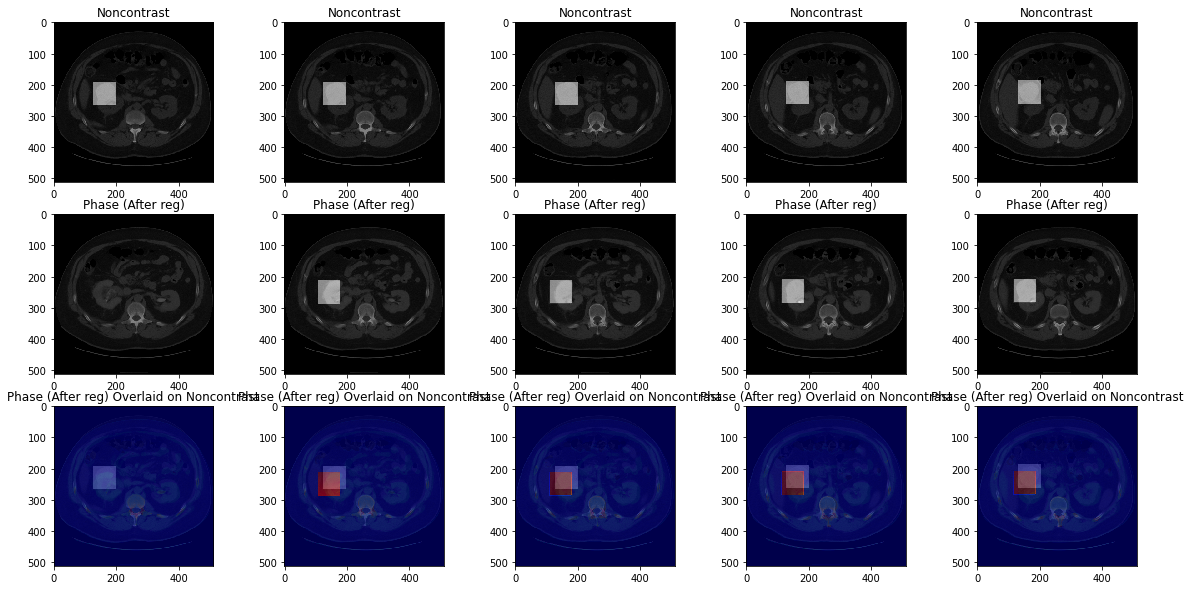

In [10]:
#cycle through patients

start = 716 # next 834
end = start+1

for i, pid in enumerate(pids[start:end]):
    print('----------------------index:', i+start, 'PID:', pid, '------------------------------')
    df_pid= df[df['Patient ID'] == pid] 

    # cycle through phases
    phases = set([a['Phase Name'] for a in list(df_pid.T.to_dict().values())])
    if "noncon" not in phases:
        print("No noncon scan")
        continue
    else:
        phases.remove("noncon")
    
    phases = [p for p in phases if os.path.isfile(os.path.join(base_dir, pid, (p+'.nii.gz')))] #make sure phase images exist in folder
    phases = [p for p in phases if get_mask_fname(base_dir, pid, p)] #make sure a mask exists in folder
    image_list = [os.path.join(base_dir, pid, (p+'.nii.gz')) for p in phases]
    mask_list = [os.path.join(base_dir, pid, get_mask_fname(base_dir, pid, p)) for p in phases]
    #mask_list = [os.path.join(base_dir, pid, 'BB_R_portven.nii.gz'), os.path.join(base_dir, pid, 'BB_R_delay_markers_1.nii.gz')]
    
    #define noncon paths and slice thickness
    d = []
    df_phase = df[(df['Patient ID'] == pid) & (df['Phase Name'] == 'noncon')]
    #df_phase = df[(df['Patient ID'] == pid) & (df['Phase Name'] == 'noncon') & (df['SeriesInstanceUID'] ==  '1.3.6.1.4.1.20319.116474239337302853091178544414365963440')]
    d.append(df_phase['Slice Thickness'].values[0])
    noncon_mask_fname = get_mask_fname(base_dir, pid, "noncon")
    image_list = [os.path.join(base_dir, pid, 'noncon.nii.gz')] + image_list
    mask_list = [os.path.join(base_dir, pid, noncon_mask_fname)] + mask_list
    #mask_list = [os.path.join(base_dir, pid, 'BB_R_noncon_markers_1.nii.gz')] + mask_list
    
    for i, phase in enumerate(phases):          
        #get phase slice thickness
        df_phase = df[(df['Patient ID'] == pid) & (df['Phase Name'] == phase)]
        d.append(df_phase['Slice Thickness'].values[0])

    print('d:', d)
    print(phases)
    if phases:
        # match ranges and crop across all phases
        minz, midz, maxz =auto_register_z(image_list, mask_list, d)

        # define new noncon paths
        noncon_nii_new = image_list[0][:-7] + '_cropped.nii.gz'
        nc_mask_nii_new = mask_list[0][:-7] + '_cropped.nii.gz'  

        for i, phase in enumerate(phases):  #register each phase to noncon
            print( '---------', phase, '---------')

            # define new phase paths
            phase_nii_new = image_list[i+1][:-7] + '_cropped.nii.gz'
            phs_mask_nii_new = mask_list[i+1][:-7] + '_cropped.nii.gz'

            try:
                phase_reg, phs_mask_reg = register_nifti_affine(noncon_nii_new, phase_nii_new, phs_mask_nii_new)
                #phase_reg, phs_mask_reg = register_nifti_syn(noncon_nii_new, phase_nii_new, phs_mask_nii_new)
            except RuntimeError:
                print("--------ITK Error--------")
            else:
                # save results
                save_path = image_list[i+1][:-7] + '_reg.nii.gz'
                save_path_mask = mask_list[i+1][:-7] + '_reg.nii.gz'
                ants.image_write(phase_reg, save_path)  
                ants.image_write(phs_mask_reg, save_path_mask)
                
                # delete intermediate cropped images
                os.remove(phase_nii_new)
                os.remove(phs_mask_nii_new)

                # visualize registration
                view_reg_path(noncon_nii_new, save_path, [midz, midz])
                view_reg_mask_path(noncon_nii_new, save_path, nc_mask_nii_new, save_path_mask, [midz, midz])
                #view_reg_path(noncon_nii_new, save_path, [maxz, maxz])
                #view_reg_mask_path(noncon_nii_new, save_path, nc_mask_nii_new, save_path_mask, [maxz, maxz])
                #view_reg_path(noncon_nii_new, save_path, [minz, minz])
                #view_reg_mask_path(noncon_nii_new, save_path, nc_mask_nii_new, save_path_mask, [minz, minz])
    else:
        print("no phase images in folder")
                

### Adjust if needed (in slice dimension -z)

(512, 512, 69)
(512, 512, 69)


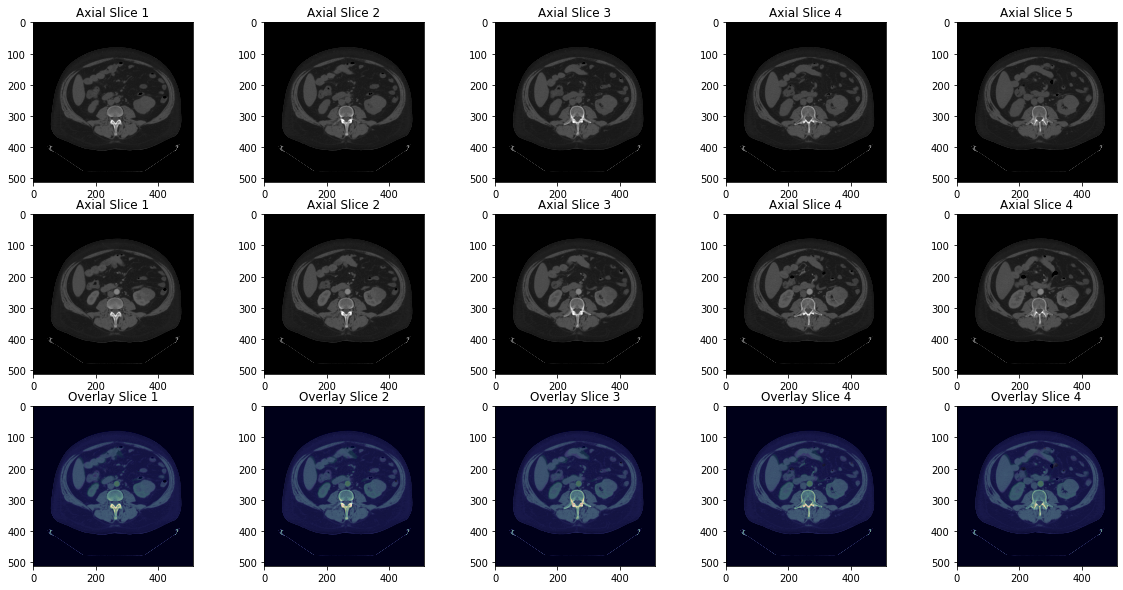

(512, 512, 69)
(512, 512, 69)


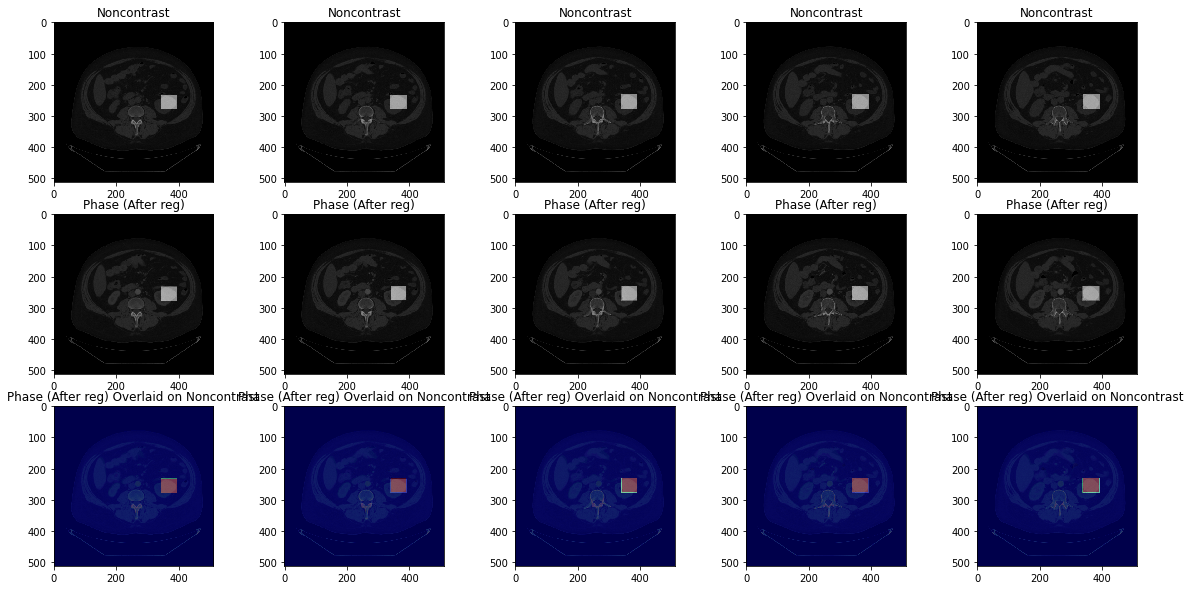

(512, 512, 69)
(512, 512, 69)


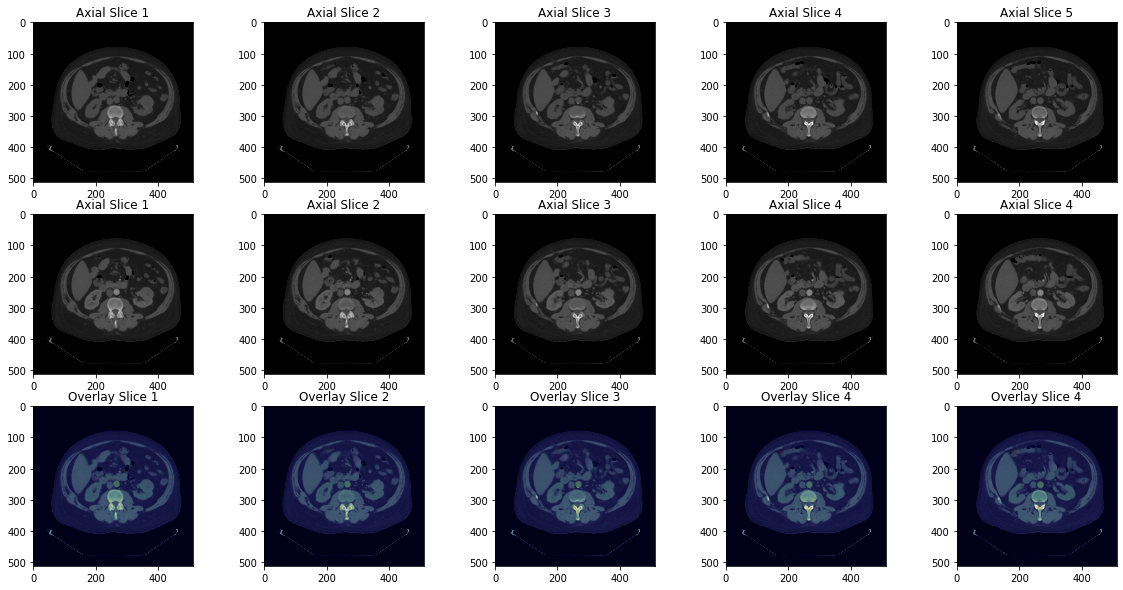

(512, 512, 69)
(512, 512, 69)


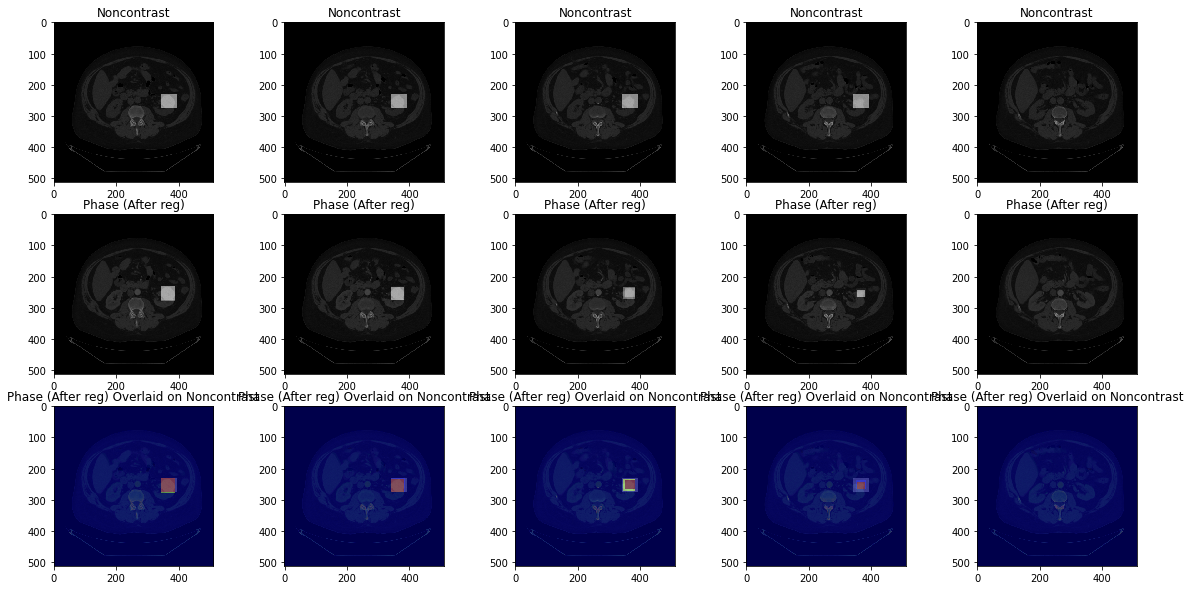

(512, 512, 69)
(512, 512, 69)


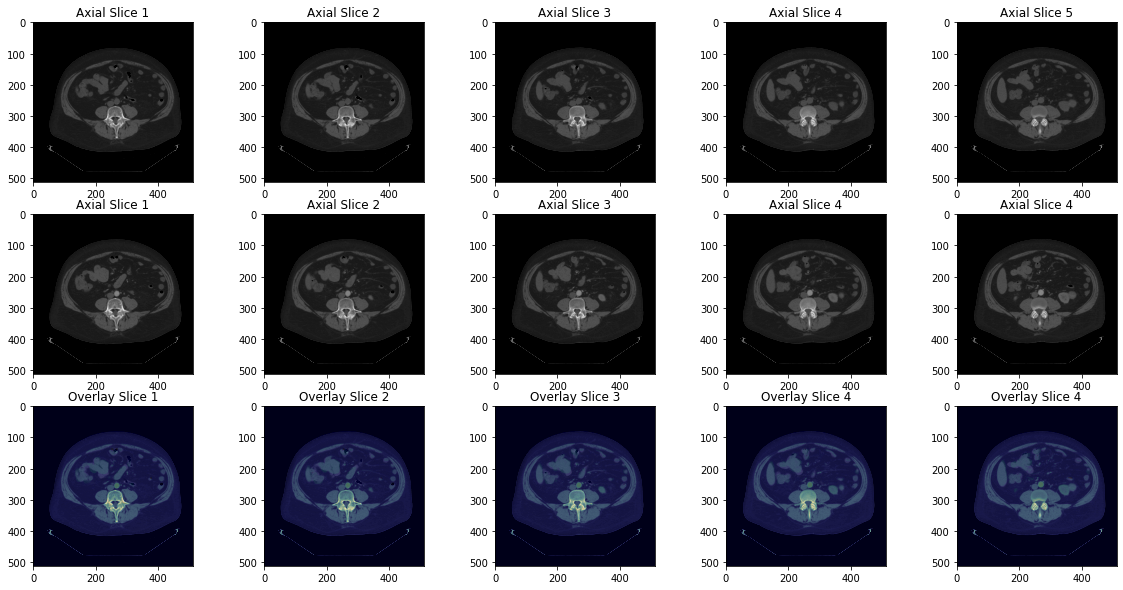

(512, 512, 69)
(512, 512, 69)


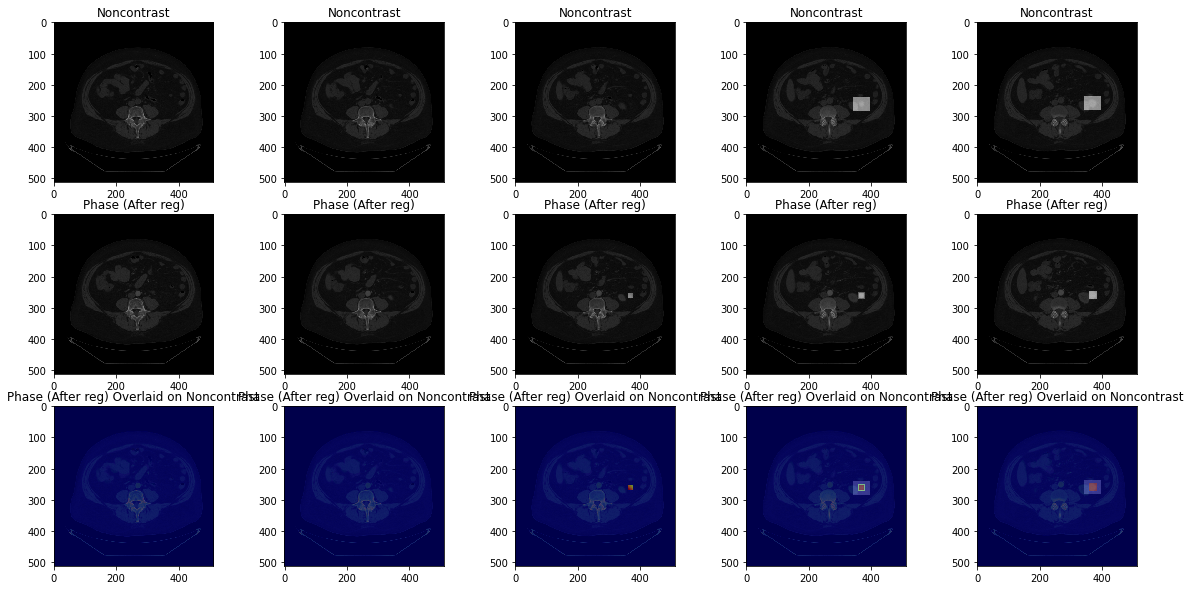

(512, 512, 69)
(512, 512, 69)


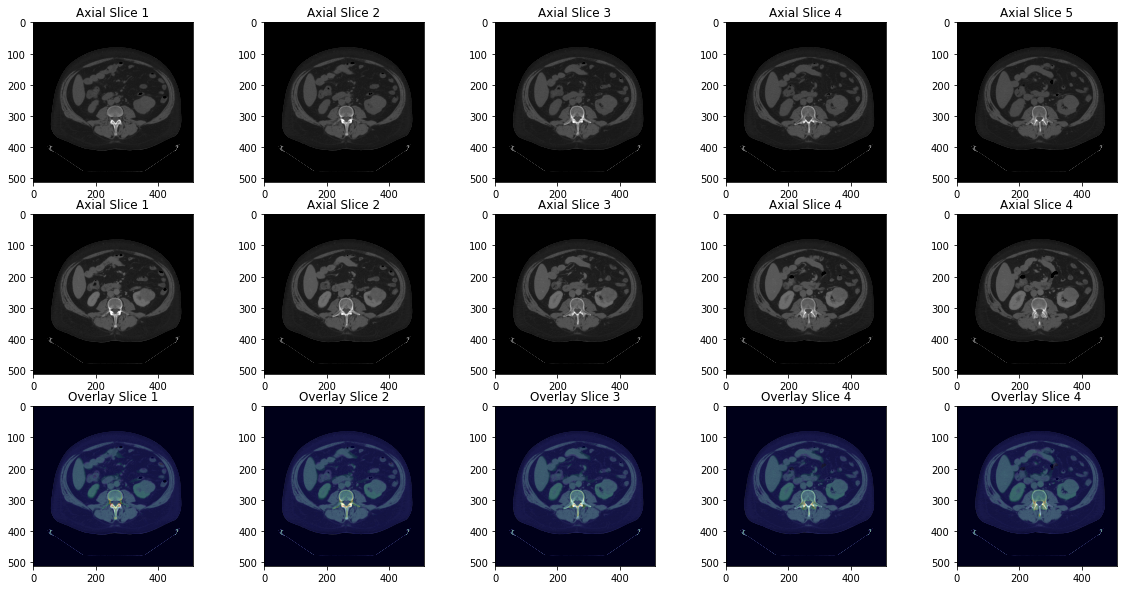

(512, 512, 69)
(512, 512, 69)


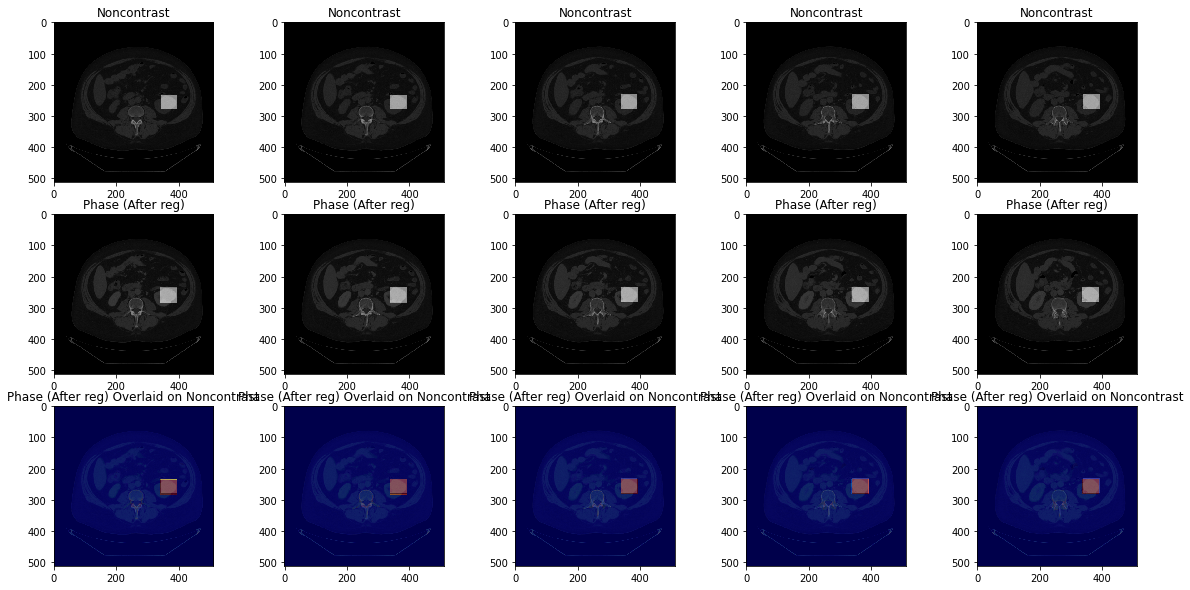

(512, 512, 69)
(512, 512, 69)


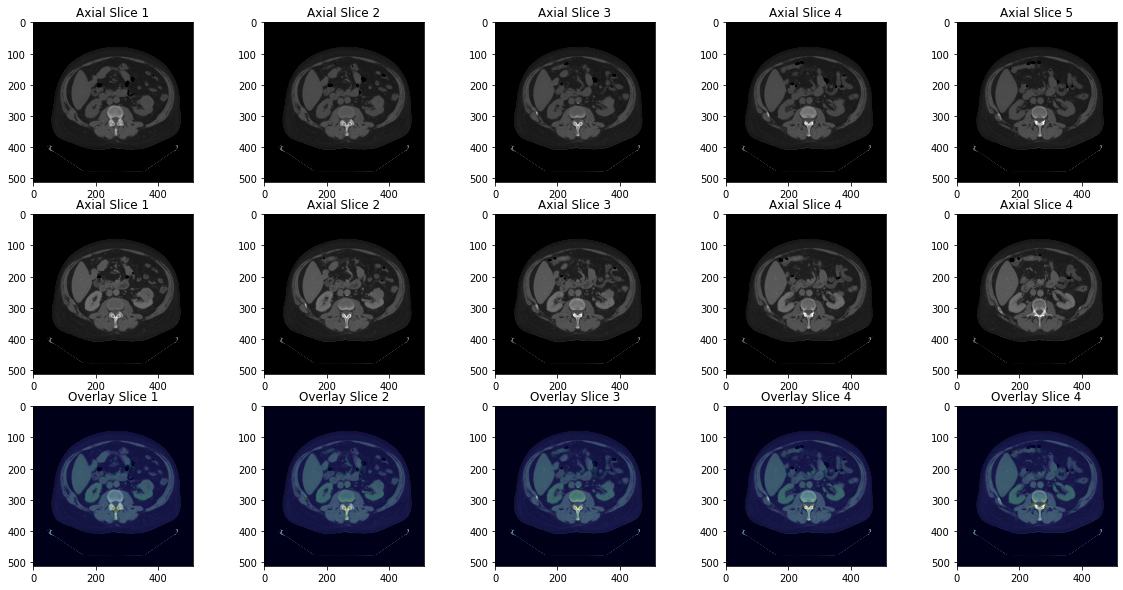

(512, 512, 69)
(512, 512, 69)


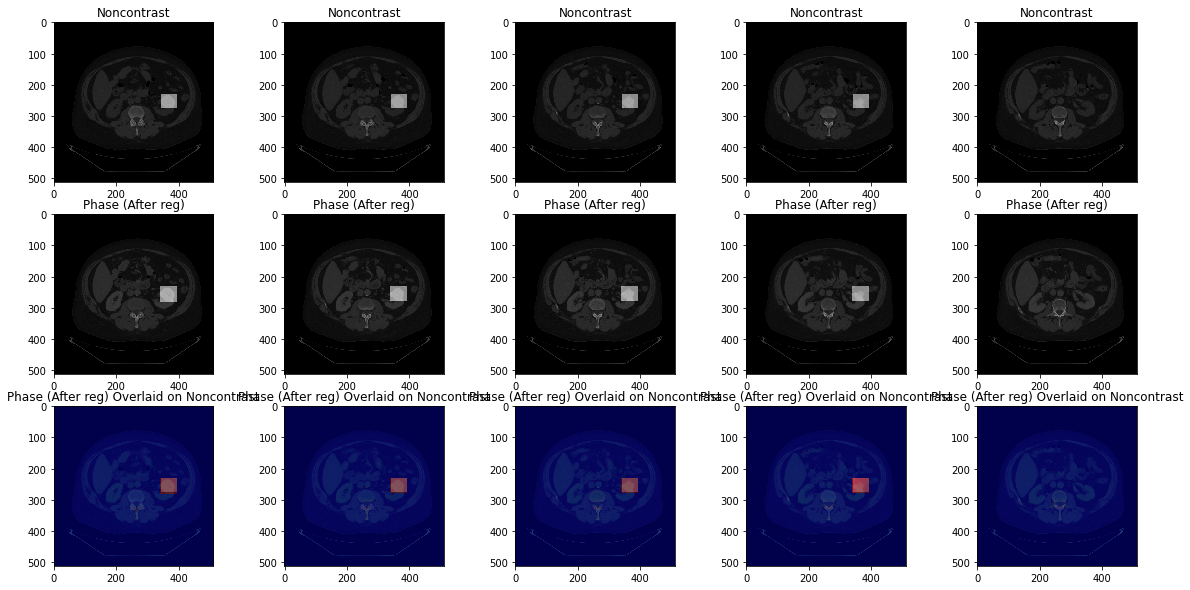

(512, 512, 69)
(512, 512, 69)


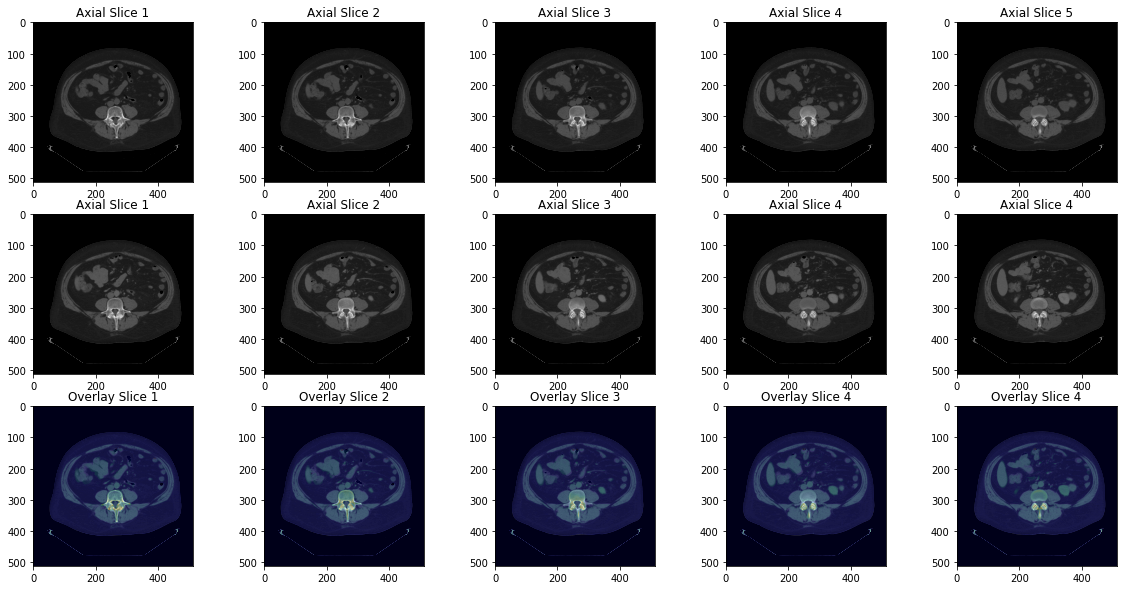

(512, 512, 69)
(512, 512, 69)


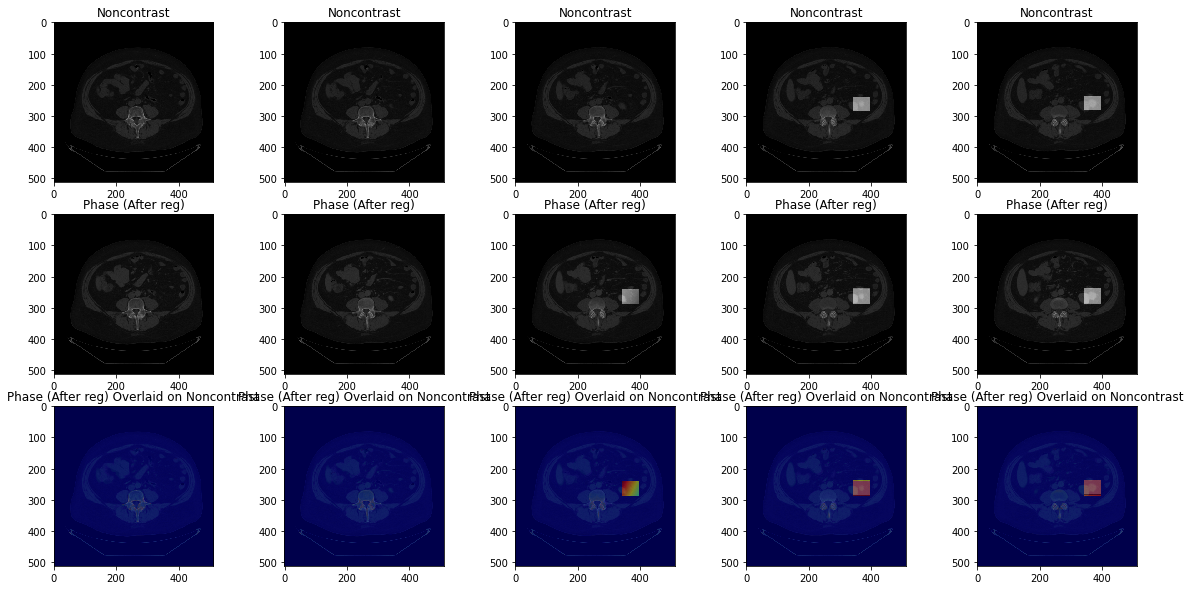

In [28]:
n=3
#zmax = 58
#save_path2 = os.path.join(base_dir, pid,'arterial_reg.nii.gz')
#save_path_mask2 = os.path.join(base_dir, pid,'BB_R_arterial_reg.nii.gz')
save_path3 = os.path.join(base_dir, pid,'portven_reg.nii.gz')
save_path_mask3 = os.path.join(base_dir, pid,'BB_R_portven_reg.nii.gz')


#adjust if needed
fix_reg_nslice(save_path, noncon_nii_new, 'down', n) #up = move phase to right, down=move phase to left  (NOTE: if up will crop noncon and have to redo reg for other phases)
fix_reg_nslice(save_path_mask, nc_mask_nii_new, 'down', n)
#crop_nifti_z(save_path, n, 85) #if using "up" crop other phases like noncon to keep registration the same
#crop_nifti_z(save_path_mask, n, 85) #if using "up" crop other phases like noncon to keep registration the same
#crop_nifti_z(save_path3, n, 97) #if using "up" crop other phases like noncon to keep registration the same
#crop_nifti_z(save_path_mask3, n, 97) #if using "up" crop other phases like noncon to keep registration the same
crop_nifti_z(save_path, 0, 70-n) 
crop_nifti_z(save_path_mask, 0, 70-n) 
#crop_nifti_z(save_path3, 0, 72-n) 
#crop_nifti_z(save_path_mask3, 0, 72-n) 


# visualize registration
view_reg_path(noncon_nii_new, save_path, [midz, midz])
view_reg_mask_path(noncon_nii_new, save_path, nc_mask_nii_new, save_path_mask, [midz, midz])
view_reg_path(noncon_nii_new, save_path, [maxz, maxz])
view_reg_mask_path(noncon_nii_new, save_path, nc_mask_nii_new, save_path_mask, [maxz, maxz])
view_reg_path(noncon_nii_new, save_path, [minz, minz])
view_reg_mask_path(noncon_nii_new, save_path, nc_mask_nii_new, save_path_mask, [minz, minz])

#view_reg_path(noncon_nii_new, save_path2, [midz, midz])
#view_reg_mask_path(noncon_nii_new, save_path2, nc_mask_nii_new, save_path_mask2, [midz, midz])
#view_reg_path(noncon_nii_new, save_path2, [maxz, maxz])
#view_reg_mask_path(noncon_nii_new, save_path2, nc_mask_nii_new, save_path_mask2, [maxz, maxz])
#view_reg_path(noncon_nii_new, save_path2, [minz, minz])
#view_reg_mask_path(noncon_nii_new, save_path2, nc_mask_nii_new, save_path_mask2, [minz, minz])

view_reg_path(noncon_nii_new, save_path3, [midz, midz])
view_reg_mask_path(noncon_nii_new, save_path3, nc_mask_nii_new, save_path_mask3, [midz, midz])
view_reg_path(noncon_nii_new, save_path3, [maxz, maxz])
view_reg_mask_path(noncon_nii_new, save_path3, nc_mask_nii_new, save_path_mask3, [maxz, maxz])
view_reg_path(noncon_nii_new, save_path3, [minz, minz])
view_reg_mask_path(noncon_nii_new, save_path3, nc_mask_nii_new, save_path_mask3, [minz, minz])



## Example Registration (One registration at a time)

In [ ]:
pid = 'nh1sRqpU6L'
phase = 'delay'
base_dir ='/data/larson2/RCC_dl/data2022/'

csv_filepath = '/data/larson2/RCC_dl/metadata/anon_metadata_phase.csv'
df = pd.read_csv(csv_filepath)
pid_df = df[(df['Patient ID'] == pid) & ((df['Phase Name'] == phase) | (df['Phase Name'] == 'noncon'))]
d= np.zeros((2))
d[0] = pid_df[pid_df['Phase Name'] == 'noncon']['Slice Thickness'].values
d[1] = pid_df[pid_df['Phase Name'] ==  phase]['Slice Thickness'].values

#define paths
noncon_nii = os.path.join(base_dir, pid, 'noncon.nii.gz')
phase_nii =  os.path.join(base_dir, pid, (phase+'.nii.gz'))
nc_mask_nii = os.path.join(base_dir, pid, 'BB_R_noncon_markers_1.nii.gz')
phs_mask_nii = os.path.join(base_dir, pid, 'BB_R_delay_markers_1.nii.gz')

#first auto register z for noncon and phase and save
[nc_img_new, nc_mask_new, phs_img_new, phs_mask_new, midz] =auto_register_z(noncon_nii, phase_nii, nc_mask_nii, phs_mask_nii, d)
noncon_nii_new = noncon_nii[:-7] + '_cropped.nii.gz'
nc_mask_nii_new = nc_mask_nii[:-7] + '_cropped.nii.gz'
phase_nii_new = phase_nii[:-7] + '_cropped.nii.gz'
phs_mask_nii_new = phs_mask_nii[:-7] + '_cropped.nii.gz'
nib.save(nc_img_new, noncon_nii_new)
nib.save(nc_mask_new, nc_mask_nii_new)
nib.save(phs_img_new, phase_nii_new)
nib.save(phs_mask_new, phs_mask_nii_new)

phase_reg, phs_mask_reg = register_nifti_affine(noncon_nii_new, phase_nii_new, phs_mask_nii_new)
#phase_reg, phs_mask_reg = register_nifti_syn(noncon_nii_new, phase_nii_new, phs_mask_nii_new)

In [114]:
# save results
save_path = '/data/larson2/RCC_dl/data2022/nh1sRqpU6L/delay_reg.nii.gz'
save_path_mask = '/data/larson2/RCC_dl/data2022/nh1sRqpU6L/BB_R_delay_markers_1_reg.nii.gz'
ants.image_write(phase_reg, save_path)
ants.image_write(phs_mask_reg, save_path_mask)
#ants.image_write(output, save_path)

# visualize registration again
view_reg_path(noncon_nii_new, save_path, [midz, midz])
view_reg_mask_path(noncon_nii_new, save_path, nc_mask_nii_new, save_path_mask, [midz, midz])
#view_reg_path(noncon_nii_new, phase_nii, phase_nii_new, [22, 22, 22])
#view_reg_mask_path(noncon_nii_new, phase_nii, phase_nii_new, nc_mask_nii_new, phs_mask_nii, phs_mask_nii_new, [22, 22, 22])